In [1]:
import pandas as pd
from gamescout_db import db, cur
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import numpy as np
import math
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import statsmodels.discrete.discrete_model as sm

In [ ]:
# DATA COLLECTION

In [ ]:
batter_stats_COLUMNS = ['HITS','1_AGO_AVG', '2_AGO_AVG', '3_AGO_AVG', '4_AGO_AVG', '5_AGO_AVG', '6_AGO_AVG','7_AGO_AVG', 'P_ID','G_ID', 'BAT_ORDER', 'G_DATE', 'TEAM']

at_bats_COLUMNS = ['BATTER', 'PITCHER', 'G_ID', 'BATTER_LR', 'PITCHER_LR', 'EVENT']

pitcher_stats_COLUMNS = ['P_ID', 'G_ID', 'GAME_SCORE', 'BATTERS_FACED', 'TEAM', 'GAME_SCORE_1AGO', 'GAME_SCORE_2AGO', 'GAME_SCORE_3AGO']

In [ ]:
batter_stats = pd.read_sql('select * from BatterStats;', con=db)[batter_stats_COLUMNS]
batter_stats["GOT_HIT"] = [1 if x > 0 else 0 for x in batter_stats["HITS"]]
batter_stats["NOT_HIT"] = [1 if x == 0 else 0 for x in batter_stats["HITS"]]

batter_stats["1_AGO"] = [0 if x == 0 else 1 for x in batter_stats["1_AGO_AVG"]]
batter_stats["2_AGO"] = [0 if x == 0 else 1 for x in batter_stats["2_AGO_AVG"]]
batter_stats["3_AGO"] = [0 if x == 0 else 1 for x in batter_stats["3_AGO_AVG"]]
batter_stats["4_AGO"] = [0 if x == 0 else 1 for x in batter_stats["4_AGO_AVG"]]
batter_stats["5_AGO"] = [0 if x == 0 else 1 for x in batter_stats["5_AGO_AVG"]]
batter_stats["6_AGO"] = [0 if x == 0 else 1 for x in batter_stats["6_AGO_AVG"]]
batter_stats["7_AGO"] = [0 if x == 0 else 1 for x in batter_stats["7_AGO_AVG"]]

batter_stats = batter_stats[['GOT_HIT', 'NOT_HIT', '1_AGO', '2_AGO', '3_AGO', '4_AGO', '5_AGO', '6_AGO','7_AGO', 'P_ID', 'G_ID', 'BAT_ORDER', 'G_DATE', 'TEAM']]

In [ ]:
pitcher_stats = pd.read_sql('select * from PitcherStats;', con=db)[pitcher_stats_COLUMNS]

In [ ]:
at_bats = pd.read_sql('select * from AtBats;', con=db)[at_bats_COLUMNS]

In [ ]:
#batter_stats = batter_stats[batter_stats['G_ID'].isin(at_bats['G_ID'].tolist())]

In [ ]:
hist_AB_series = []
hist_H_series = []
OPP_ID_series = []
GS1AGO_series = []
GS2AGO_series = []
GS3AGO_series = []
order_series = []

for i in range(0, 100):
    batter = batter_stats.ix[i]
    starting_pitcher = pitcher_stats[pitcher_stats['G_ID'] == batter['G_ID']]
    starting_pitcher = starting_pitcher[pitcher_stats['TEAM'] != batter['TEAM']]
    starting_pitcher = starting_pitcher.sort(['BATTERS_FACED'], ascending=False).head(1)
    matchups = at_bats[at_bats['BATTER'] == batter['P_ID']]
    matchups = matchups[matchups['PITCHER'] == starting_pitcher['P_ID'].iloc[0]]
    matchups = matchups[matchups['G_DATE'] < batter['G_DATE']]
    matchups_hits = matchups[matchups['EVENT'].isin(['Single', 'Double', 'Triple', 'Home Run'])]
    hist_AB = len(matchups)
    hist_H = len(matchups_hits)

    hist_AB_series.append(hist_AB)
    hist_H_series.append(hist_H)
    OPP_ID_series.append(starting_pitcher['P_ID'].iloc[0])

    GS1AGO_series.append(starting_pitcher['GAME_SCORE_1AGO'].iloc[0])
    GS2AGO_series.append(starting_pitcher['GAME_SCORE_2AGO'].iloc[0])
    GS3AGO_series.append(starting_pitcher['GAME_SCORE_3AGO'].iloc[0])
    order_series.append(batter['BAT_ORDER'])
    
    if i % 1000 == 0:
        print i
    
batter_stats['hist_AB'] = pd.Series(hist_AB_series)
batter_stats['hist_H'] = pd.Series(hist_H_series)
batter_stats['starting_P_ID'] = pd.Series(OPP_ID_series)
batter_stats['GS1AGO'] = pd.Series(GS1AGO_series)
batter_stats['GS2AGO'] = pd.Series(GS2AGO_series)
batter_stats['GS3AGO'] = pd.Series(GS3AGO_series)
batter_stats['BAT_ORDER'] = pd.Series(order_series)

In [ ]:
# batter_stats.to_csv('SAVED.csv')

## Logistic Regression

### Prof. Sun's Logistic Regression Model Code

In [2]:
def logistic(z):
    return 1 / (1 + np.exp(-z))

In [3]:
def logistic_regression(X, y):
    beta = np.zeros(X.shape[1])
    for _ in range(5):
        p = logistic(np.dot(X, beta))
        w = p * (1 - p)
        beta += np.linalg.solve(np.dot(X.T, (w[:, np.newaxis] * X)), np.dot(X.T, y - p))
        
    p = logistic(np.dot(X, beta))
    w = p * (1 - p)
    se = np.sqrt(np.diag(np.linalg.inv(np.dot(X.T, (w[:, np.newaxis] * X)))))
    
    return beta, se

In [ ]:
len(compiled)

In [5]:
compiled = pd.read_sql('select * from Compiled;', con=db)
graph = pd.read_sql('select count(*) from Compiled where G_DATE = \'2017-05-31\';', con=db)
num_pitchers = pd.read_sql('select distinct count(starting_P_ID) from Compiled;', con=db)
num_batters = pd.read_sql('select distinct count(P_ID) from Compiled;', con=db)

In [6]:
num_pitchers = num_pitchers['count(starting_P_ID)'][0]
num_batters = num_batters['count(P_ID)'][0]
yesterday = graph['count(*)'][0]

In [7]:
games_played_b = compiled.groupby('P_ID').size()
joined = compiled.join(pd.DataFrame(games_played_b, columns=['GAMES_PLAYED_B']), on=['P_ID'])

In [8]:
games_played_p = compiled.groupby(['starting_P_ID', 'G_ID']).size().reset_index().groupby('starting_P_ID').size()
joined = joined.join(pd.DataFrame(games_played_p, columns=['GAMES_PLAYED_P']), on=['starting_P_ID'])

In [9]:
joined['P_ID'] = [777 if joined['GAMES_PLAYED_B'][x] < 100 else joined['P_ID'][x] for x in range(len(joined))]

In [10]:
joined['starting_P_ID'] = [888 if joined['GAMES_PLAYED_P'][x] < 20 else joined['starting_P_ID'][x] for x in range(len(joined))]

In [11]:
data = joined
data = data[pd.notnull(data['GS1AGO'])]
data = data[pd.notnull(data['GS2AGO'])]
data = data[pd.notnull(data['GS3AGO'])]

labels = data['GOT_HIT']
data = data[['1_AGO', '2_AGO', '3_AGO', '4_AGO', '5_AGO', '6_AGO', '7_AGO', 'GS1AGO', 'GS2AGO', 'GS3AGO', 
             'starting_P_ID', 'P_ID', 'hist_AB', 'hist_H']]

data = pd.concat([data, pd.get_dummies(data['starting_P_ID']).iloc[:,1:num_pitchers]], axis=1)
data = pd.concat([data, pd.get_dummies(data['P_ID']).iloc[:,1:num_batters]], axis=1)

In [12]:
# H^1.2 - (.1 * AB^1.2)

data['Gamma'] = data['hist_H'] - (.1 * data['hist_AB'])
#plt.scatter(data['hist_H'], data['hist_AB'], s=.1)
#plt.hist(data['Gamma'])

In [13]:
data = data.drop('starting_P_ID', 1)                                            
data = data.drop('P_ID', 1)                                                     
data = data.drop('hist_AB', 1)                                                  
data = data.drop('hist_H', 1)  

In [14]:
y = labels
x = data

In [15]:
train_x = x[:250000]
test_x = x[250001:]

train_y = y[:250000]
test_y = y[250001:]

#### Professor's Model

In [ ]:
# use our logistic regression function
beta, se = logistic_regression(train_x, train_y)

# calculate the z-score for each coefficient
z = beta / se
z

In [ ]:
# compare the z-scores we got above with statsmodels
from statsmodels.api import Logit
model = Logit(train_y, train_x)
results = model.fit()
results.summary()

### Our Linear Regression Model



In [16]:
model = linear_model.LogisticRegression(class_weight='balanced')
model.fit(train_x, train_y)

#for index, col in enumerate(x.columns):
#    print("{0}: {1}".format(col, model.coef_[0][index]))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
#logit = sm.Logit(y, x)

In [25]:
#f = logit.fit()
len(data.columns)

1410

In [17]:
#f.summary()
test_x = data[-yesterday:]
test_y = y[-yesterday:]

In [ ]:
model.predict_proba()

(array([ 51.,  72.,  55.,  29.,  14.,  11.,  21.,  81.,  23.,  58.]),
 array([ 0.17659453,  0.25776251,  0.33893049,  0.42009847,  0.50126645,
         0.58243443,  0.66360241,  0.74477039,  0.82593837,  0.90710635,
         0.98827433]),
 <a list of 10 Patch objects>)

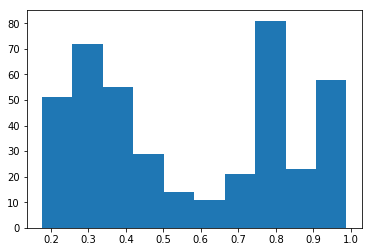

In [18]:
plt.hist(model.predict_proba(test_x)[:,0])

In [19]:
predicted = model.predict(test_x)
expected = test_y

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       0.75      0.69      0.72       229
          1       0.65      0.72      0.68       186

avg / total       0.71      0.70      0.70       415

[[157  72]
 [ 52 134]]


In [ ]:
model.score(test_x, test_y)

In [ ]:
# DO OUR FEATURES CORRELATE TO PERFORMANCE?

In [20]:
probs = model.predict_proba(test_x)[:,1]
pairs = zip(expected, probs)

In [21]:
prob_bins = {}
x = np.array([probs])
bins = np.linspace(0, 1, num=101)

inds = np.digitize(x, bins)

for i, pair in enumerate(pairs):
    key = str(inds[0][i] - 1)
    
    if key not in prob_bins:
        #print(key)
        prob_bins[key] = []
        
    prob_bins[key].append(pair)

In [22]:
pct_hit = []
for key in sorted(prob_bins.keys()):
    hits = [sum(x) for x in zip(*prob_bins[str(key)])][0]
    total = len(prob_bins[str(key)])
    pct = float(hits)/float(total)
    pct_hit.append(pct)

#     print("Bin: " + str(key))
#     print("# players w/ hit: " + str(hits))
#     print("# player (total): " + str(total))
#     print("Pct. Hit: " + str(float(hits)/float(total)))
#     print("")

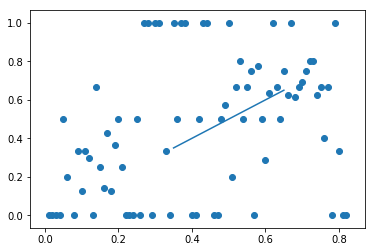

In [23]:
plt.scatter(sorted([float(i)/100 for i in prob_bins.keys()]),pct_hit)
plt.plot([0.35, 0.65], [0.35, 0.65], "-")

In [ ]:
len(data.columns)

In [ ]:
data.apply(lambda x: np.all(x==0))

In [ ]:
len(data.columns)